In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os, alive_progress
from alive_progress import alive_bar

from itertools import combinations
from scipy.stats import mannwhitneyu as mwu
from utils import VD_A as vda
from utils import apfd
from utils import cartesian
from utils import derive_data
from utils import sort_vda
from utils import calc_s12

def _interp_addsorted(alist, datapoints=[]):
    cc_dp = alist.copy()
    for newdp in datapoints:
        if(newdp in cc_dp): continue
        cc_dp = np.insert(cc_dp,np.searchsorted(cc_dp,newdp),newdp)
    return cc_dp

def interp(data: pd.DataFrame.dtypes, col_costs: str, col_hypsizes: str, datapoints=[]):
    df_subset = data.copy()
    df_subset[col_hypsizes+'_withdatapoints']=df_subset[col_hypsizes].apply(lambda x: _interp_addsorted(x,datapoints))
    df_subset[col_costs]=df_subset.apply(lambda x: np.interp(x[col_hypsizes+'_withdatapoints'], x[col_hypsizes], x[col_costs]),axis=1)
    df_subset[col_hypsizes]=df_subset[col_hypsizes+'_withdatapoints']
    df_subset.drop(col_hypsizes+'_withdatapoints',inplace=True,axis=1)
    return df_subset


# set inline print
%matplotlib inline

os.makedirs(f'data/img/', exist_ok=True)

# Load CSV, calculate APFD and filter Equivalent==OK

In [2]:
df_fixed = pd.concat([pd.read_csv(os.path.join(pth)) for pth in ["k_1_k_2_hads_hsi_w_wp_h_fixed.csv", "k_1_k_2_spy_spyh.csv", "log_iads_fixed.csv"]])
df_fixed = derive_data(df_fixed)
df_fixed.EquivalenceOracle=df_fixed.CTT
df_fixed['Type'] = 'Fixed'

df_random = pd.concat([pd.read_csv(os.path.join(pth)) for pth in  ["random_final.csv", "log_iads_random.csv"]])
df_random = derive_data(df_random)
df_random.EquivalenceOracle=df_random.apply(lambda x: x.CTT+','+str(x['Random Infix Length']), axis=1)
df_random['Type'] = 'Random'
df_random['EquivalenceOracle'] = pd.Categorical(df_random['EquivalenceOracle'], 
  [f'{x[0]},{x[1]}' for x in list(cartesian((["H-ADS", "HSI", "Wp", "W", "I-ADS"], df_random['Random Infix Length'].unique()))
)])

# Concatenate dataframes and derive AFPD

In [3]:
# equivs_drv = pd.concat([df_fixed])
equivs_drv = pd.concat([df_fixed,df_random])
equivs_drv = pd.merge(equivs_drv, pd.read_csv(os.path.join("SUL_list.csv")), how='left',on='SUL name')
equivs_drv = equivs_drv.query(f'`Equivalent`=="OK" and `Extra States`==2')

# Plot %states detected per test case (for all methods)

In [4]:
# define figure DPI
sns.set(rc={'figure.dpi':400})
sns.set_palette("colorblind")
sns.set_style("whitegrid")


all_runs = equivs_drv[['SUL name']].drop_duplicates()
# all_runs = equivs_drv.query(f'`SUL name`in ["TCP_Linux_Client.dot"]')[['SUL name']].drop_duplicates()
total = len(all_runs)

new_dps = list(range(10,101,10))
new_dps.reverse()

# methods = ["W", "Wp", "SPY", "H-ADS"]
methods = ["W", "Wp", "HSI", "H", "SPY", "SPY-H", "H-ADS"]
with alive_bar(total, force_tty=True, title=f'Plotting APFD') as bar:
    for idx,row in all_runs.iterrows():
        # get an entry <SUL, seed>
        sulname = row['SUL name']
        fname=sulname.replace('.dot','')
        subj=equivs_drv.query(f'`SUL name`=="{sulname}" and `Type`=="Fixed" and `CTT` in @methods').copy()
        
        apfd_tab = subj[['CTT','MQ','EQ','TC','Rounds','APFD_s2']].sort_values(['APFD_s2'],ascending=False)
        apfd_tab.to_csv(f'data/img/{fname}.csv')
        
        # add percent columns
        subj['HypSizePercent'] = subj['HypSize'].apply(lambda x: x/np.max(x)*100)

        # analyze qtype column 
        qtype = 'Total cost'
        
        subj_interp=interp(data=subj, col_costs=qtype,col_hypsizes='HypSizePercent', datapoints=new_dps)
        subj_interp=subj_interp.explode(['HypSizePercent',qtype])
        subj_interp=subj_interp.query('HypSizePercent in @new_dps').sort_values(by=[qtype],ascending=False)

        cols_order = subj_interp['CTT'].drop_duplicates().to_list()
        cols_order.reverse()

        the_cols = ['SUL name','HypSizePercent','CTT']
        subj_gb=subj_interp[[*the_cols,qtype]].groupby(the_cols).first()

        subj_pvt = subj_gb.pivot_table(qtype,['CTT'],'HypSizePercent').sort_values(by=list(new_dps))
        #subj_pvt = subj_pvt/subj_pvt.max().max()
        heatmap_cost=sns.heatmap(subj_pvt,
                         annot=True, fmt=",.0f", annot_kws={'rotation': 0, 'fontsize':9}, 
                         cmap= sns.cm.rocket_r, linewidth=.5, linecolor='black'
                        )

        #add plot labels, titles and legends
        plt.xlabel('Fraction of the SUL learned')
        plt.ylabel('')
        #plt.legend(title='Testing Technique', loc='lower right')
        plt.title(f'Interpolation of {qtype}')

        # save line chart
        fig = heatmap_cost.get_figure()
        plt.gcf().set_size_inches(30,20)
        fig.savefig(f'data/img/{fname}_heatmap.pdf', bbox_inches='tight')
        fig.clf()
        
        # explode qtype column with % of cost and hypothesis sizes in the learning process
        subj=subj.explode(['HypSizePercent',qtype])
        subj[[*the_cols,qtype]].to_csv(f'data/img/{fname}_HypSizePercent.csv')

        #create line chart
        apfd_plot = sns.lineplot(subj, x=f'{qtype}', y='HypSizePercent',
                                 markers=True, 
                                 style='CTT', hue='CTT',
                                 palette='tab10'
                                )
        apfd_plot.set(xscale='linear', yscale='linear')
        apfd_plot.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True,useOffset=True, useLocale=True))
        apfd_plot.yaxis.set_major_formatter(ticker.PercentFormatter())
        
        #add plot labels, titles and legends
        plt.xlabel(f'{qtype.title()}')
        plt.ylabel('')
        _sulname=sulname.replace('.dot','')
        plt.title(f'Subject: {_sulname}\nFraction of the SUL learned vs. {qtype}')

        #get handles and labels
        handles, labels = plt.gca().get_legend_handles_labels()

        #specify order of items in legend from APFD
        order = subj[['CTT','APFD_s2']].sort_values(['APFD_s2'],ascending=False).drop_duplicates().CTT.to_list()
        for idx,ctt in enumerate(order): order[idx]=labels.index(ctt)
        #add legend to plot
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                   title='Testing Technique', loc='lower right', 
                   fontsize='xx-small', title_fontsize='xx-small')

        # save line chart
        fig = apfd_plot.get_figure()
        plt.gcf().set_size_inches(8,5)
        fig.savefig(f'data/img/{fname}.pdf', bbox_inches='tight')
        fig.clf()
        
        bar()

Plotting APFD |████████████████████████████████████████| 46/46 [100%] in 1:43.5 


<Figure size 3200x2000 with 0 Axes>

# Draw boxplots and Tables for TC and APFD

In [5]:
dict_of_metrics = {'all':['TC_s1', 'TC_s2','APFD_s1', 'APFD_s2']
                   #,'analysis':['TC_s1', 'APFD_s2']
                   #,'s2':['TC_s2', 'APFD_s2']
                   #, 'apfds':['APFD_s1', 'APFD_s2']
                  }

for ctt_mode in equivs_drv.Type.unique():
    dataset = equivs_drv.query(f'`Type`=="{ctt_mode}"')\
                .sort_values(['SUL name','EquivalenceOracle','Seed'])\
                .copy()
    metrics_s12 = calc_s12(dataset).reset_index()
    if(ctt_mode == 'Fixed'): 
        metrics_s12['EquivalenceOracle'] = pd.Categorical(metrics_s12['EquivalenceOracle'], ["W", "Wp", "HSI", "H", "SPY", "SPY-H", "H-ADS", "I-ADS"])
    else:
        metrics_s12[['CTT', 'RIL']] = metrics_s12.EquivalenceOracle.str.split(",", expand = True)
        metrics_s12['CTT'] = pd.Categorical(metrics_s12['CTT'], ["W", "Wp", "HSI", "H-ADS", "I-ADS"])
    display(metrics_s12)
    for metric_name,metrics_to_plot in dict_of_metrics.items():
        
        for metric in metrics_to_plot:
            results=metrics_s12.sort_values(['SUL name','EquivalenceOracle'])\
                        .groupby(['EquivalenceOracle'])\
                        .apply(lambda x: x[metric].tolist())\
                        .reset_index().sort_values(['EquivalenceOracle'],ascending=False)
            results=results.reindex(index=results.index[::-1])
            # apply combination method
            results = dict(zip(list(combinations(results['EquivalenceOracle'], 2)),list(combinations(results[0], 2))))
            results = pd.DataFrame.from_dict(results, orient='index').reset_index()
            results['mwu'] = results.apply(lambda x: mwu(x[0],x[1]).pvalue,axis=1)
            results['mwu<0.05'] = results['mwu']<0.05
            results[['vda_estimate','vda_magnitude']] = results.apply(lambda x: pd.Series(vda(x[0],x[1])),axis=1)
            results[['A','B']] = results['index'].apply(lambda x: pd.Series([x[0],x[1]]))
            results.drop([0,1,'index'],axis=1,inplace=True)
            results.set_index(['A','B'],inplace=True)
            results.columns.name = f'{metric} ({ctt_mode})'
            results.to_csv(f'data/{ctt_mode}_{metric}.csv', float_format='%.4f')
            results.style.to_latex(f'data/{ctt_mode}_{metric}.tex', column_format='%.4f')

            # initialize figure with 1 subplot
            fig, ax = plt.subplots(1, 1, figsize=(4.5,3), dpi=400)

            # add padding between the subplots
            plt.subplots_adjust(wspace=0.2,hspace=0.3)
            
            idx=0
            # draw plots
            if(ctt_mode == 'Fixed'): 
                sns.boxplot(data=metrics_s12, ax=ax, x='EquivalenceOracle',y=metric,flierprops={"marker": "x"})
            else:
                sns.boxplot(data=metrics_s12, ax=ax, x='CTT',y=metric,hue='RIL',flierprops={"marker": "x"})
                ax.legend(title='Infix Length', loc='lower right',fontsize='xx-small', title_fontsize='xx-small')
            ax.set_xlabel('')
            ax.set_ylabel(metric.split('_')[0])
            ax.tick_params(axis='x', rotation=0, labelsize=8)
            if not "APFD_" in metric: 
                ax.set(yscale='log')
            else:
                ax.yaxis.set_ticks(np.arange(0, 0.1, 1.0))

            ##add overall title to replot
            #fig.suptitle(f'{ctt_mode} mode')

            # save line chart
            fig.savefig(f'data/{ctt_mode}_{metric}.pdf', bbox_inches='tight')
            fig.clf()


,EquivalenceOracle,SUL name,TC_s1,APFD_s1,TC_s2,APFD_s2
0,H,10_learnresult_MasterCard_fix.dot,52408,0.730111,0.423951,0.941318
1,H,1_learnresult_MasterCard_fix.dot,17572,0.396614,0.662594,0.6002
2,H,4_learnresult_MAESTRO_fix.dot,52408,0.730111,0.423951,0.941318
3,H,4_learnresult_PIN_fix.dot,52408,0.730111,0.423951,0.941318
4,H,4_learnresult_SecureCode Aut_fix.dot,31440,0.746676,1.0,0.850043
...,...,...,...,...,...,...
363,Wp,learnresult_fix.dot,69837,0.591047,0.770352,0.684962
364,Wp,miTLS_0.1.3_server_regular.dot,7166,0.746883,0.251996,0.936216
365,Wp,model1.dot,1687658,0.945577,0.890015,0.987284
366,Wp,model3.dot,32072294,0.850083,0.886479,0.867102


,EquivalenceOracle,SUL name,TC_s1,APFD_s1,TC_s2,APFD_s2,CTT,RIL
0,"H-ADS,2",10_learnresult_MasterCard_fix.dot,5830,0.774385,0.256005,0.951752,H-ADS,2
1,"H-ADS,2",10_learnresult_MasterCard_fix.dot,945,0.550617,0.041497,0.984423,H-ADS,2
2,"H-ADS,2",10_learnresult_MasterCard_fix.dot,9047,0.799528,0.397269,0.933473,H-ADS,2
3,"H-ADS,2",10_learnresult_MasterCard_fix.dot,2489,0.714008,0.109296,0.973889,H-ADS,2
4,"H-ADS,2",10_learnresult_MasterCard_fix.dot,1608,0.649876,0.07061,0.979349,H-ADS,2
...,...,...,...,...,...,...,...,...
23455,"Wp,3",model4.dot,48266,0.626002,0.284307,0.956796,Wp,3
23456,"Wp,3",model4.dot,83011,0.654965,0.48897,0.931449,Wp,3
23457,"Wp,3",model4.dot,37154,0.611905,0.218853,0.965489,Wp,3
23458,"Wp,3",model4.dot,43942,0.553532,0.258837,0.953044,Wp,3


<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

# Write tables for TC and APFD

TypeError: 'Axes' object is not subscriptable

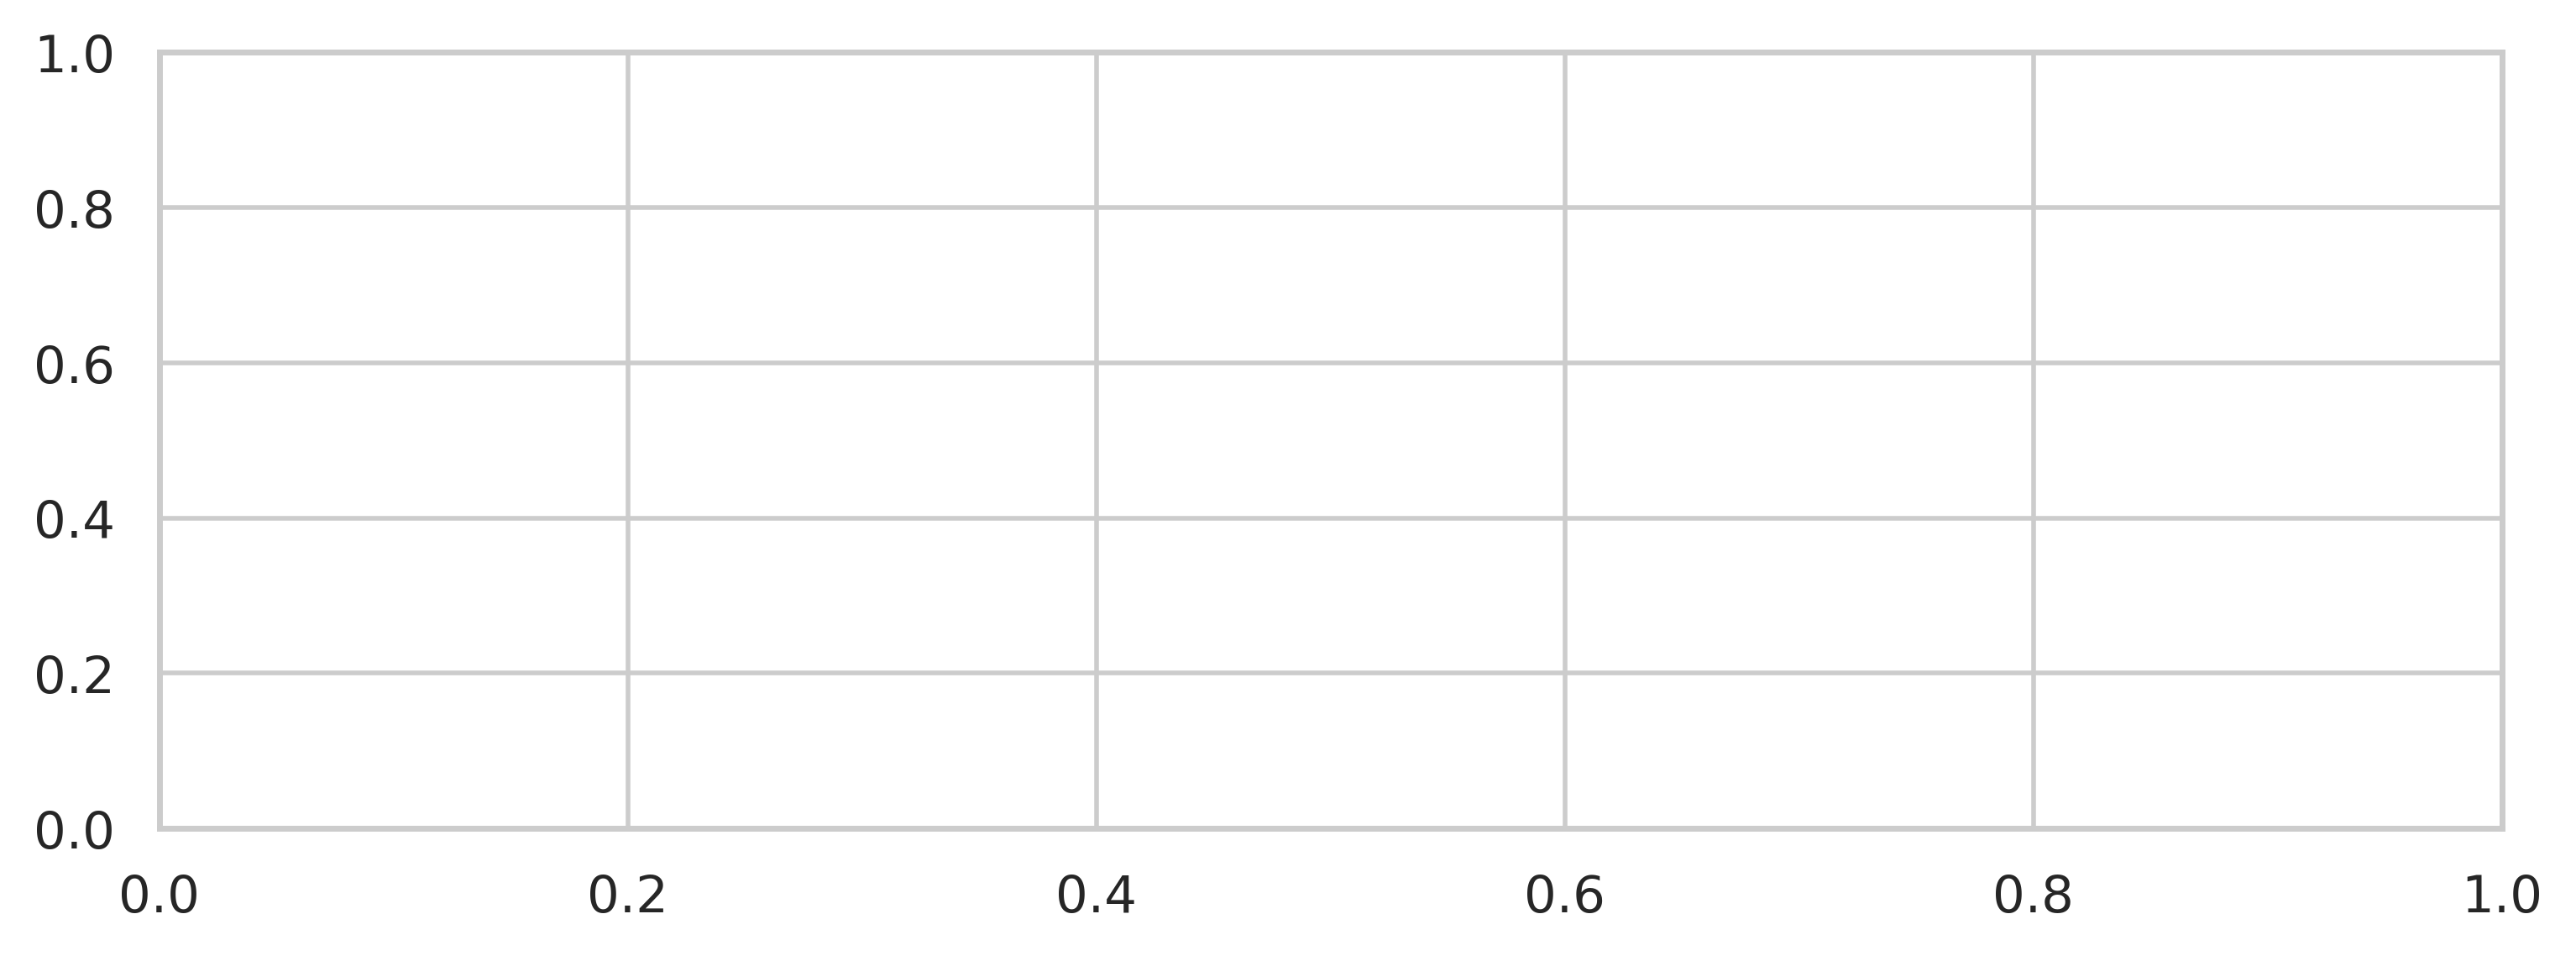

In [6]:
# only for those experiments where an equivalent hypothesis was achieved and smallest ES parameter
str_eqv_es2='`Equivalent`=="OK" and `Extra States`==2'

# calculate the means for each metric below 
metrics=['TC', 'TC [Symbols]', 'MQ', 'EQ', 'APFD_s1', 'APFD_s2']
# then group them by these columns
groups=['Type','CTT', 'Extra States','Random Infix Length', 'SUL name']
fix_vs_rnd = pd.concat([
    df_random.query(f'{str_eqv_es2} and `Random Infix Length`==2')[[*groups,*metrics]].groupby(groups).mean().reset_index(),
    df_fixed.query(f'{str_eqv_es2}')[[*groups,*metrics]].reset_index()
])

# name EQOracles based on CTT name and Mode (there is just one ES and RIL setting)
fix_vs_rnd['EquivalenceOracle'] = fix_vs_rnd.apply(lambda x: x.CTT+','+x.Type, axis=1)

# only focus on those CTTs were run in both Fixed and Random modes
methods_rnd = ["W", "Wp", "HSI", "H-ADS", "I-ADS"]
fix_vs_rnd=fix_vs_rnd.query('CTT in @methods_rnd')
fix_vs_rnd['CTT'] = pd.Categorical(fix_vs_rnd['CTT'], methods_rnd)

# calculate the S1 metric
dataset = fix_vs_rnd.sort_values(['SUL name','EquivalenceOracle']).copy()
metrics_s12 = calc_s12(dataset).reset_index()

# recover the CTT names and Mode type 
metrics_s12[['CTT', 'Type']] = metrics_s12.EquivalenceOracle.str.split(",", expand = True)
metrics_s12['CTT'] = pd.Categorical(metrics_s12['CTT'], methods_rnd)

# draw plots and write tables to analyze the Best of Each (BoE) mode
ctt_mode='BoE'

# the analyzed metrics are TC_s1 and APFD_s2 (aka APFD_L)
dict_of_metrics = {'analysis':['TC_s1', 'APFD_s2']}
for metric_name,metrics_to_plot in dict_of_metrics.items():
    # for each metric
    for metric in metrics_to_plot:
        # put the measurements in a list ordered bu SUL name and CTT 
        results=metrics_s12.sort_values(['SUL name','EquivalenceOracle'])\
                    .groupby(['Type'])\
                    .apply(lambda x: x[metric].tolist())\
                    .reset_index().sort_values(['Type'],ascending=False)
        results=results.reindex(index=results.index[::-1]) # drop the index column 
        
        # apply combination method to analyze all pairs of CTT modes
        results = dict(zip(list(combinations(results['Type'], 2)),list(combinations(results[0], 2))))
        results = pd.DataFrame.from_dict(results, orient='index').reset_index()
        
        # then calculate the Mann–Whitney U test
        results['mwu'] = results.apply(lambda x: mwu(x[0],x[1]).pvalue,axis=1)
        # mark those significant
        results['mwu<0.05'] = results['mwu']<0.05
        # pick the results of the Vargha and Delaney's A (VDA) effect size
        results[['vda_estimate','vda_magnitude']] = results.apply(lambda x: pd.Series(vda(x[0],x[1])),axis=1)
        results[['A','B']] = results['index'].apply(lambda x: pd.Series([x[0],x[1]]))
        # polishing the colums
        results.drop([0,1,'index'],axis=1,inplace=True); results.set_index(['A','B'],inplace=True)
        results.columns.name = f'{metric}'
        # then save the tables as CSV and TeX
        results.to_csv(f'data/{ctt_mode}_{metric}.csv', float_format='%.4f')
        results.style.to_latex(f'data/{ctt_mode}_{metric}.tex', column_format='%.4f')
        
        # initialize figure with 2 subplots in a row
        fig, ax = plt.subplots(1, 1, figsize=(9,3), dpi=400)

        # add padding between the subplots
        plt.subplots_adjust(wspace=0.2,hspace=0.3)
        
        idx=0
        # draw plots for one metric
        sns.boxplot(data=metrics_s12, ax=ax[idx], x='CTT',y=metric, hue='Type',flierprops={"marker": "x"})
        ax[idx].set_xlabel('')
        ax[idx].set_ylabel(metric.split('_')[0])
        #ax[idx].set_xlim([0,1])
        ax[idx].tick_params(axis='x', rotation=0, labelsize=8)
        legend_loc='lower right'
        if "_s1" in metric and not "APFD_" in metric: 
            ax[idx].set(yscale='log')
            legend_loc='upper right'
        idx_inc=idx_inc+1
        ax[idx].legend(title='Mode', loc=legend_loc,fontsize='xx-small', title_fontsize='xx-small')

        # save line chart
        fig.savefig(f'data/{ctt_mode}_{metric}.pdf', bbox_inches='tight')
        fig.clf()